<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Model Tuning
              
</p>
</div>

Data Science Cohort Live NYC Nov 2022
<p>Phase 3: Topic 29</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [34]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

#### Hyperparameters
- Free knobs of a model used to **control the training process**.

<img src = "Images\levers.jpg" width = 350/><center> Tuning your model!! </center>

**Hyperparameters concerning the structure of cost function and model**

#### Hyperparameters
- Free levers of a model used to **control the training process**.
- $\lambda$: the regularization parameter for $|\textbf{w}|^2$ penalty.


#### Parameters

- **Found by training the model**
- Weights ($\textbf{w}$, etc.): 
    Logistic Regression, Linear Regression


#### Hyperparameters
- depth of decision tree
- gini impurity or entropy?

#### Parameters

- Locations in feature space where splits were made

**Hyperparameters concerning the optimization process**

- Can help get to solutions faster
- Get *better* convergence to cost function minimum

**Solvers for Logistic regression**: variants of gradient descent.

- lbfgs (variant of Newton method)
    - accounts for concavity of cost function
- sag (Stochastic Gradient Descent)
    - fast convergence
    - excellent for larger number of samples
- liblinear (Coordinate Descent)
    - better for larger number of features



Depending on the sort of problem and data:
- experiment with different values of these hyperparameters
- improve model performance.

Running through the entire process of train/test splitting and cross-validation yet again:

Load iris data

In [35]:
iris_df = pd.read_csv('Data/Iris.csv').drop(columns = ['Id'])
iris_df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Label encode the target class

In [4]:
from sklearn.preprocessing import LabelEncoder
target_transform = LabelEncoder()
iris_df['Species'] = target_transform.fit_transform(iris_df['Species'])
iris_df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Select two of the features and the target. Features are not obviously separable.
- Tuning will be important.

In [5]:
col_list = ['SepalWidthCm', 'SepalLengthCm']
X = iris_df[col_list]
y = iris_df['Species']

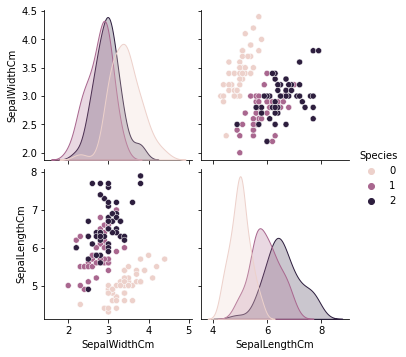

In [6]:
sns.pairplot(hue = 'Species', 
             vars = col_list,
             data = iris_df)
plt.show()

Now, before doing anything: Train/test split!

In [36]:
# shuffle and split, stratify keeps target distribution same in train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.15, random_state = 42)

In [37]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

In [38]:
def cross_validation(X_train, y_train, k, num_split = 10):
    
    X_train = X_train.values
    y_train = y_train.values
    
    score_train_list = []
    score_val_list = []
    
    for train_index, valid_index in KFold(n_splits = num_split).split(X_train):
        # train and validation splitting 
        X_train_fold, X_val_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[valid_index]

        #create/fit the Standard scaler on the train fold
        scaler = StandardScaler()
        X_tf_sc = scaler.fit_transform(X_train_fold)
        # transform validation fold
        X_vld_sc = scaler.transform(X_val_fold)

        # create/fit knearest neighbor
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_tf_sc, y_train_fold)
        
        # now how did we do?
        accuracy_train = knn.score(X_tf_sc, y_train_fold)
        accuracy_val = knn.score(X_vld_sc, y_val_fold)
        score_val_list.append(accuracy_val)
        score_train_list.append(accuracy_train)
    
    return {'k': k, 'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

Now for tuning parameters need to loop:

In [10]:
# empty dataframe
crossval_df = pd.DataFrame(columns = ['k', 'train', 'validation'])
# append results for each value of k
for k in np.arange(1,100):
    crossval_df = crossval_df.append(cross_validation(X_train, y_train, k, 5), ignore_index = True)


In [11]:
crossval_df.head()

,k,train,validation
0,1.0,0.948825,0.717231
1,2.0,0.870103,0.764308
2,3.0,0.876024,0.756308
3,4.0,0.848437,0.779692
4,5.0,0.848437,0.779692


Technically, we did this correctly. But...

#### Whats the problem with this?

- Need to write unecessary code. Hard to read.
- Easy to mess up: track each data transformation carefully.
- Changing/adding transformations: possibly a pain.
- For loops for tuning, etc.

#### The goal:

- want to get best model in streamlined process.
- want to be able to plug in and out different transformations easily and transparently. 
- try multiple transformations/models at once
- want good reporting/ranking of different models.

####  First part of solution: The pipeline 

- Transformer fitting and model fitting
- Happen one right after the other.
- **Ideal: unify into a single process.**

Without the pipeline:
- have to repeat fit and transformer/predicting for every transformer and model

In [12]:
# Define transformers (will adjust/massage the data)
imputer = SimpleImputer(strategy="median") # replaces missing values
std_scaler = StandardScaler() # scales the data

# Define the classifier (predictor) to train
rf_clf = DecisionTreeClassifier(random_state=42)

# Have the classifer (and full pipeline) learn/train/fit from the data
X_train_filled = imputer.fit_transform(X_train)
X_train_scaled = std_scaler.fit_transform(X_train_filled)
rf_clf.fit(X_train_scaled, y_train)

# Predict using the trained classifier (still need to do the transformations)
X_test_filled = imputer.transform(X_test)
X_test_scaled = std_scaler.transform(X_test_filled)
y_pred = rf_clf.predict(X_test_scaled)
print(y_pred)

[1 1 2 2 0 2 0 0 2 1 0 2 1 1 0 0 0 1 2 0 1 0 1]


Instead let's use the Pipeline object

In [13]:
from sklearn.pipeline import Pipeline

# this will allow us to visualize the pipeline (may not be available in learn-env)
from sklearn import set_config
set_config(display= 'diagram')

Pipeline() constructor:
- takes in list of tuples (steps):
- user label of estimator/transformer in pipeline (a string)
- the transformer/estimator


Pipeline() object is a new estimator:
- does all steps in a defined order
- transformers in the beginning
- predictive model must be last step

Combining into a unified estimator-transformer:
- single .fit()
- single .predict()

**Does everything in one shot**

Let's check this out on fitting/predicting with simple train/test split:

In [14]:
steps = [('imputer', SimpleImputer(strategy="median")), ('std_scaler', StandardScaler()),
        ('rf_clf', DecisionTreeClassifier(random_state=42))]

pipeline = Pipeline(steps)


# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)
print(predicted)

[1 1 2 2 0 2 0 0 2 1 0 2 1 1 0 0 0 1 2 0 1 0 1]


Side by side (they do the same thing)

In [15]:
# Define transformers (will adjust/massage the data)
imputer = SimpleImputer(strategy="median") # replaces missing values
std_scaler = StandardScaler() # scales the data

# Define the classifier (predictor) to train
rf_clf = DecisionTreeClassifier(random_state=42)

# Have the classifer (and full pipeline) learn/train/fit from the data
X_train_filled = imputer.fit_transform(X_train)
X_train_scaled = std_scaler.fit_transform(X_train_filled)
rf_clf.fit(X_train_scaled, y_train)

# Predict using the trained classifier (still need to do the transformations)
X_test_filled = imputer.transform(X_test)
X_test_scaled = std_scaler.transform(X_test_filled)
y_pred = rf_clf.predict(X_test_scaled)
print(y_pred)

[1 1 2 2 0 2 0 0 2 1 0 2 1 1 0 0 0 1 2 0 1 0 1]


In [16]:
steps = [('imputer', SimpleImputer(strategy="median")), ('std_scaler', StandardScaler()),
        ('rf_clf', DecisionTreeClassifier(random_state=42))]

pipeline = Pipeline(steps)


# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)
print(predicted)

[1 1 2 2 0 2 0 0 2 1 0 2 1 1 0 0 0 1 2 0 1 0 1]


Now lets do **manual** cross validation **with pipeline**

First advantage: can define the entire set of transformations outside cross-validation function:

In [17]:
# Can define outside the cross validation
steps = [('imputer', SimpleImputer(strategy="median")), ('std_scaler', StandardScaler()),
        ('rf_clf', DecisionTreeClassifier(random_state=42))]

model_pipe = Pipeline(steps)
model_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('std_scaler', StandardScaler()),
                ('rf_clf', DecisionTreeClassifier(random_state=42))])

Second advantage: no keeping track of multiple variables.
- single .fit() and .predict()

In [18]:
def cross_validation_pip(X_train, y_train, estimator, num_split = 10):
    
    X_train = X_train.values
    y_train = y_train.values
    
    score_train_list = []
    score_val_list = []
    
    for train_index, valid_index in KFold(n_splits = num_split).split(X_train):
        
        # train and validation splitting 
        X_train_fold, X_val_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[valid_index]

        estimator.fit(X_train_fold, y_train_fold)
        
        # now how did we do?
        accuracy_train = estimator.score(X_train_fold, y_train_fold)
        accuracy_val = estimator.score(X_val_fold, y_val_fold)
        score_val_list.append(accuracy_val)
        score_train_list.append(accuracy_train)
    
    return {'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

In [19]:
cross_validation_pip(X_train, y_train, pipeline)

{'train': 0.943119755911518, 'validation': 0.708974358974359}

Compare manual cross-validation **without** pipeline:

In [20]:
def cross_validation(X_train, y_train, estimator, num_split = 10):
    
    X_train = X_train.values
    y_train = y_train.values
    
    score_train_list = []
    score_val_list = []
    
    for train_index, valid_index in KFold(n_splits = num_split).split(X_train):


        # train and validation splitting 
        X_train_fold, X_val_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[valid_index]
        
        # impute NaNs with medians
        
        simple_imp = SimpleImputer(strategy="median")
        X_tf_imp = simple_imp.fit_transform(X_train_fold)
        X_vld_imp = simple_imp.transform(X_val_fold)

        #create/fit the Standard scaler on the train fold
        scaler = StandardScaler()
        X_tf_sc = scaler.fit_transform(X_tf_imp)
        
        # transform validation fold
        X_vld_sc = scaler.transform(X_vld_imp)

        estimator.fit(X_tf_sc, y_train_fold)
        
        # now how did we do?
        accuracy_train = estimator.score(X_tf_sc, y_train_fold)
        accuracy_val = estimator.score(X_vld_sc, y_val_fold)
        score_val_list.append(accuracy_val)
        score_train_list.append(accuracy_train)
    
    return {'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

In [21]:
dec_tree = DecisionTreeClassifier(random_state=42)
cross_validation(X_train, y_train, dec_tree)

{'train': 0.943119755911518, 'validation': 0.708974358974359}

Same result as pipeline but:
- Much less customizable/plug and play
- Have to be careful and keep track of variables.
- Changing/adding steps requires changing code **carefully** in function
- Track changes and follow order of transformations:
    - train set
    - test set

<img src = "Images/pipeline_vs_manual.png" width = 600  /> <center>Pipeline: customizable box. <i>Takes care of the details.</i></center>

#### Swapping in Different Models & Transformers

Pipeline object has the steps as an attribute:
- Python list
- can modify pipeline progression by modifying attribute.

In [22]:
model_pipe.steps

[('imputer', SimpleImputer(strategy='median')),
 ('std_scaler', StandardScaler()),
 ('rf_clf', DecisionTreeClassifier(random_state=42))]

Change model to KNN:

In [23]:
# pop the decision tree
model_pipe.steps.pop(-1)
# insert knn
model_pipe.steps.append(
['knn', KNeighborsClassifier()])

In [24]:
model_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('std_scaler', StandardScaler()),
                ['knn', KNeighborsClassifier()]])

Can change transformers in the middle:

In [25]:
model_pipe.steps[1] = ('norm', Normalizer())
model_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('norm', Normalizer()), ['knn', KNeighborsClassifier()]])

#### Pipelines
- Easily plug/play different transformers and models into our workflow

#### Pipelines clearly awesome, but:

Transformer/model pipeline hyperparameter tuning with cross-validation still pretty manual:

Want:
- Efficient hyperparameter tuning with minimal code
- Leakage prevention
- Automatic best model selection and reporting on the CV for each pipeline tried. 


#### The CV Grid Search

Scikit-Learn has a [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class whose `fit()` method:

- takes in a grid of hyperparameters
- loops through all of them **in order**
- runs cross-validation properly scoring by chosen metric


- Returns all the models fitted
- Can easily access best model and its score

<center><img src = "Images/hyperparameter_tuning_cv_grid.webp" width = 400/></center>

#### GridSearchCV

In [26]:
# let's define a new pipeline object 

steps = [('imputer', SimpleImputer(strategy="median")), ('std_scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())]

model_pipe = Pipeline(steps)

CV takes in a grid dictionary:
- with pipeline: key must follow a specific format
- "pipelinename__hyperparameter"

With pipeline:
- Can change hyperparameters of model
- **Also** can change hyperparameters of transformers.

In [27]:

pipe_grid = {'imputer__strategy': ["mean", "median"],
             'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 18],
             'knn__p': [1, 2, 3, 4]}

# note: default scoring is aaccuracy
gs_pipe = GridSearchCV(estimator=model_pipe, 
                       param_grid=pipe_grid)


In [28]:
gs_pipe.fit(X_train, y_train);

In [29]:
gs_pipe.best_params_

{'imputer__strategy': 'mean', 'knn__n_neighbors': 18, 'knn__p': 1}

In [30]:
gs_pipe.best_score_

0.811076923076923

Get the best estimator

In [31]:
best_model = gs_pipe.best_estimator_
best_model

Pipeline(steps=[('imputer', SimpleImputer()), ('std_scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=18, p=1))])

Evaluate on the test

In [32]:
y_pred = best_model.predict(X_test)

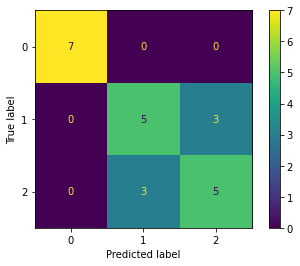

In [39]:
plot_confusion_matrix(best_model, X_test, y_test)
#ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test);

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.62      0.62      0.62         8
           2       0.62      0.62      0.62         8

    accuracy                           0.74        23
   macro avg       0.75      0.75      0.75        23
weighted avg       0.74      0.74      0.74        23



Can also get full report of cross validation with the pipeline estimators:
- e.g. a dataframe with all the models

In [41]:
cv_result_df = pd.DataFrame(gs_pipe.cv_results_)
cv_result_df = cv_result_df.sort_values(by = 'rank_test_score')
cv_result_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_imputer__strategy,param_knn__n_neighbors,param_knn__p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
60,0.002946,0.000011,0.002080,0.000060,median,18,1,"{'imputer__strategy': 'median', 'knn__n_neighb...",0.769231,0.846154,0.8,0.76,0.88,0.811077,0.045746,1
28,0.003131,0.000209,0.002241,0.000117,mean,18,1,"{'imputer__strategy': 'mean', 'knn__n_neighbor...",0.769231,0.846154,0.8,0.76,0.88,0.811077,0.045746,1
61,0.002948,0.000004,0.002052,0.000013,median,18,2,"{'imputer__strategy': 'median', 'knn__n_neighb...",0.769231,0.807692,0.8,0.80,0.84,0.803385,0.022577,3
29,0.003037,0.000175,0.002177,0.000110,mean,18,2,"{'imputer__strategy': 'mean', 'knn__n_neighbor...",0.769231,0.807692,0.8,0.80,0.84,0.803385,0.022577,3
62,0.003007,0.000070,0.002166,0.000062,median,18,3,"{'imputer__strategy': 'median', 'knn__n_neighb...",0.769231,0.769231,0.8,0.80,0.84,0.795692,0.026080,5


Trying different metrics:
- Default scoring was accuracy
- But can try other with scoring = ''

- Takes string:
    - 'average_precision'
    - 'balanced_accuracy' (class averaged recall)
    - 'roc_auc', etc.

In [42]:
pipe_grid = {'imputer__strategy': ["mean", "median"],
             'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 18],
             'knn__p': [1, 2, 3, 4]}

gs_pipe = GridSearchCV(estimator=model_pipe, 
                       param_grid=pipe_grid, scoring = 'precision_micro')

In [43]:
gs_pipe.fit(X_train, y_train);
best_est = gs_pipe.best_estimator_

In [44]:
best_est

Pipeline(steps=[('imputer', SimpleImputer()), ('std_scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=18, p=1))])

Obviously not enough search parameters: still gets same model
- Also probably limited by intrinsic overlap in the data.
- Will see another example of trying different metrics.

#### In this case:
- Not many NaNs
- Selected subset of data didn't require multiple types of transformers
    - e.g. categorical vs. numeric columns
    - ordinal vs. nominal categoricals
    - feature engineering on column subsets (Polynomial, etc.)


#### Column Transformers

First step in:
- dealing with systematically imputing data in pipelines
- transforming features of various types in different ways

In [45]:
salary_df = pd.read_csv('Data/adult.csv', usecols = ['age', 'occupation', 'education', 'native.country', 
                                                     'hours.per.week', 'sex', 'income'])
salary_df = salary_df[salary_df["native.country"] == "United-States"]
ed_list = ['10th','11th','HS-grad', 'Some-college', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Masters', 'Doctorate']
salary_df = salary_df[salary_df['education'].isin(ed_list)].drop(columns = ['native.country'])

Salary prediction problem:
- Predict whether someone makes >50K anually
- Numeric and categorical features require different preparation
- NaN imputation strategies specific to columns

Let's learn how to implement all this in the Pipeline

In [46]:
salary_df.head()

,age,education,occupation,sex,hours.per.week,income
0,90,HS-grad,?,Female,40,<=50K
1,82,HS-grad,Exec-managerial,Female,18,<=50K
2,66,Some-college,?,Female,40,<=50K
4,41,Some-college,Prof-specialty,Female,40,<=50K
5,34,HS-grad,Other-service,Female,45,<=50K


In [47]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27249 entries, 0 to 32560
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             27249 non-null  int64 
 1   education       27249 non-null  object
 2   occupation      27249 non-null  object
 3   sex             27249 non-null  object
 4   hours.per.week  27249 non-null  int64 
 5   income          27249 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.5+ MB


Nulls clearly encoded as '?'
- Would do EDA before figuring out how to clean/preprocess columns
- But lets go ahead and develop pipeline!

**Imputation**
- Numeric: impute with mean
- Education/occupation/sex: most common

**Encoding**
- Education: ordinal encoding
- Occupation/Sex: one-hot encoding

Then standardize and model.

In [48]:
salary_df['education'].value_counts()

HS-grad         9702
Some-college    6740
Bachelors       4766
Masters         1527
Assoc-voc       1289
11th            1067
Assoc-acdm       982
10th             848
Doctorate        328
Name: education, dtype: int64

No nans? Guess again!

In [49]:
salary_df.head()

,age,education,occupation,sex,hours.per.week,income
0,90,HS-grad,?,Female,40,<=50K
1,82,HS-grad,Exec-managerial,Female,18,<=50K
2,66,Some-college,?,Female,40,<=50K
4,41,Some-college,Prof-specialty,Female,40,<=50K
5,34,HS-grad,Other-service,Female,45,<=50K


In [50]:
# replace with NaNs
salary_df = salary_df.replace({'?':np.nan})
salary_df.head(3)

,age,education,occupation,sex,hours.per.week,income
0,90,HS-grad,NaN,Female,40,<=50K
1,82,HS-grad,Exec-managerial,Female,18,<=50K
2,66,Some-college,NaN,Female,40,<=50K


In [51]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27249 entries, 0 to 32560
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             27249 non-null  int64 
 1   education       27249 non-null  object
 2   occupation      25766 non-null  object
 3   sex             27249 non-null  object
 4   hours.per.week  27249 non-null  int64 
 5   income          27249 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.5+ MB


In [52]:
from sklearn.preprocessing import LabelEncoder

In [53]:
X_income = salary_df.drop(columns = ["income"])
y_income = salary_df['income']

In [54]:
lab_enc = LabelEncoder()
y_income = lab_enc.fit_transform(y_income)

#### Before doing anything else

In [55]:
X_inc_train, X_inc_test, y_inc_train, y_inc_test = train_test_split(X_income, y_income, test_size = 0.15)

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer

Create three separate transformation pipelines:
- Ordinal Categorical
- Nominal Categorical
- Numeric 

In [57]:
X_income.head()

,age,education,occupation,sex,hours.per.week
0,90,HS-grad,NaN,Female,40
1,82,HS-grad,Exec-managerial,Female,18
2,66,Some-college,NaN,Female,40
4,41,Some-college,Prof-specialty,Female,40
5,34,HS-grad,Other-service,Female,45


What do we want to use for each column?

## First define the separate pipelines

In [58]:
numeric_pipeline = Pipeline([('numimputer', SimpleImputer(strategy = 'mean')), ('numnorm', StandardScaler())])

ordinal_pipeline = Pipeline([
    ('ordimputer', SimpleImputer(strategy = 'most_frequent')),
    ('ordenc', OrdinalEncoder(categories = [ed_list])),
    ('ordnorm', StandardScaler())])

nominal_pipeline = Pipeline([
    ('onehotimputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehotenc', OneHotEncoder(sparse = False, drop = 'first')), 
    ('onehotnorm', MaxAbsScaler())])

ed_list

['10th',
 '11th',
 'HS-grad',
 'Some-college',
 'Assoc-acdm',
 'Assoc-voc',
 'Bachelors',
 'Masters',
 'Doctorate']

Now unite them with ColumnTransformer:
- specify columns each pipeline acts on.

In [59]:
num_cols = X_inc_train.select_dtypes(['int', 'float']).columns

ct = ColumnTransformer(
    [("ordinalpipe", ordinal_pipeline, ['education']), 
     ("nominalpipe", nominal_pipeline, ['occupation','sex']),
     ("numpipe", numeric_pipeline, num_cols)])

num_cols

Index(['age', 'hours.per.week'], dtype='object')

Viewing the transformed data:
- In order specified by column transformer

In [60]:
pd.DataFrame(ct.fit_transform(X_inc_train)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.740569,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.389073,1.185744
1,-0.214505,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.805726,-0.447661
2,-0.740569,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.015698,-0.039310
3,-0.740569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.701825,-0.039310
4,1.363688,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.538423,0.450712


Let's view what our preprocessing pipeline does:

In [61]:
ct

ColumnTransformer(transformers=[('ordinalpipe',
                                 Pipeline(steps=[('ordimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordenc',
                                                  OrdinalEncoder(categories=[['10th',
                                                                              '11th',
                                                                              'HS-grad',
                                                                              'Some-college',
                                                                              'Assoc-acdm',
                                                                              'Assoc-voc',
                                                                              'Bachelors',
                                                                              'Masters',
                                                                              'Doctorate']])),
                                                 ('ordnorm',
                                                  StandardScaler())]),
                                 ['education']),
                                ('nominalpipe',
                                 Pipeline(steps=[('onehotimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotenc',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False)),
                                                 ('onehotnorm',
                                                  MaxAbsScaler())]),
                                 ['occupation', 'sex']),
                                ('numpipe',
                                 Pipeline(steps=[('numimputer',
                                                  SimpleImputer()),
                                                 ('numnorm',
                                                  StandardScaler())]),
                                 Index(['age', 'hours.per.week'], dtype='object'))])

Takes specified columns:
- Applies ordinal pipeline to first set
- Nominal pipeline to second subset
- Numeric pipeline to last set

Joins result *in column transform order* at the end.

Column transformer: access/change individual steps in branches
- .named_transformers_ attribute as dictionary of transformers

In [62]:
ct.named_transformers_

{'ordinalpipe': Pipeline(steps=[('ordimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordenc',
                  OrdinalEncoder(categories=[['10th', '11th', 'HS-grad',
                                              'Some-college', 'Assoc-acdm',
                                              'Assoc-voc', 'Bachelors',
                                              'Masters', 'Doctorate']])),
                 ('ordnorm', StandardScaler())]),
 'nominalpipe': Pipeline(steps=[('onehotimputer', SimpleImputer(strategy='most_frequent')),
                 ('onehotenc', OneHotEncoder(drop='first', sparse=False)),
                 ('onehotnorm', MaxAbsScaler())]),
 'numpipe': Pipeline(steps=[('numimputer', SimpleImputer()), ('numnorm', StandardScaler())])}

In [63]:
ct.named_transformers_['ordinalpipe']

Pipeline(steps=[('ordimputer', SimpleImputer(strategy='most_frequent')),
                ('ordenc',
                 OrdinalEncoder(categories=[['10th', '11th', 'HS-grad',
                                             'Some-college', 'Assoc-acdm',
                                             'Assoc-voc', 'Bachelors',
                                             'Masters', 'Doctorate']])),
                ('ordnorm', StandardScaler())])

In [64]:
ct.named_transformers_['nominalpipe']

Pipeline(steps=[('onehotimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotenc', OneHotEncoder(drop='first', sparse=False)),
                ('onehotnorm', MaxAbsScaler())])

In [65]:
ct.named_transformers_['nominalpipe'].steps.pop(-1)


('onehotnorm', MaxAbsScaler())

In [66]:
ct.named_transformers_['nominalpipe'].steps.append([
    ('onehotnorm', StandardScaler())
])

In [67]:
ct.named_transformers_

{'ordinalpipe': Pipeline(steps=[('ordimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordenc',
                  OrdinalEncoder(categories=[['10th', '11th', 'HS-grad',
                                              'Some-college', 'Assoc-acdm',
                                              'Assoc-voc', 'Bachelors',
                                              'Masters', 'Doctorate']])),
                 ('ordnorm', StandardScaler())]),
 'nominalpipe': Pipeline(steps=[('onehotimputer', SimpleImputer(strategy='most_frequent')),
                 ('onehotenc', OneHotEncoder(drop='first', sparse=False)),
                 [('onehotnorm', StandardScaler())]]),
 'numpipe': Pipeline(steps=[('numimputer', SimpleImputer()), ('numnorm', StandardScaler())])}

In [68]:
ct

ColumnTransformer(transformers=[('ordinalpipe',
                                 Pipeline(steps=[('ordimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordenc',
                                                  OrdinalEncoder(categories=[['10th',
                                                                              '11th',
                                                                              'HS-grad',
                                                                              'Some-college',
                                                                              'Assoc-acdm',
                                                                              'Assoc-voc',
                                                                              'Bachelors',
                                                                              'Masters',
                                                                              'Doctorate']])),
                                                 ('ordnorm',
                                                  StandardScaler())]),
                                 ['education']),
                                ('nominalpipe',
                                 Pipeline(steps=[('onehotimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotenc',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False)),
                                                 ('onehotnorm',
                                                  MaxAbsScaler())]),
                                 ['occupation', 'sex']),
                                ('numpipe',
                                 Pipeline(steps=[('numimputer',
                                                  SimpleImputer()),
                                                 ('numnorm',
                                                  StandardScaler())]),
                                 Index(['age', 'hours.per.week'], dtype='object'))])

Swapped out MaxAbScaler with StandardScaler in nominalpipe:

At this point: 
- append modeling step
- build final pipeline: transformers + model
- tuck into gridCV for tuning.

In [69]:
final_pipe = Pipeline([('preprocess', ct),
                      ('model',
                       KNeighborsClassifier())])
final_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('ordinalpipe',
                                                  Pipeline(steps=[('ordimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordenc',
                                                                   OrdinalEncoder(categories=[['10th',
                                                                                               '11th',
                                                                                               'HS-grad',
                                                                                               'Some-college',
                                                                                               'Assoc-acdm',
                                                                                               'Assoc-voc',
                                                                                               'Bachelors',
                                                                                               'Masters',
                                                                                               'Doctorate']])),
                                                                  ('ordnorm',
                                                                   StandardScaler())]),
                                                  ['education']),
                                                 ('nominalpipe',
                                                  P...e(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['occupation', 'sex']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('numimputer',
                                                                   SimpleImputer()),
                                                                  ('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours.per.week'], dtype='object'))])),
                ('model', KNeighborsClassifier())])

Fit the full transformer and model pipeline.

In [70]:
final_pipe.fit(X_inc_train, y_inc_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('ordinalpipe',
                                                  Pipeline(steps=[('ordimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordenc',
                                                                   OrdinalEncoder(categories=[['10th',
                                                                                               '11th',
                                                                                               'HS-grad',
                                                                                               'Some-college',
                                                                                               'Assoc-acdm',
                                                                                               'Assoc-voc',
                                                                                               'Bachelors',
                                                                                               'Masters',
                                                                                               'Doctorate']])),
                                                                  ('ordnorm',
                                                                   StandardScaler())]),
                                                  ['education']),
                                                 ('nominalpipe',
                                                  P...e(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['occupation', 'sex']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('numimputer',
                                                                   SimpleImputer()),
                                                                  ('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours.per.week'], dtype='object'))])),
                ('model', KNeighborsClassifier())])

In [71]:
y_pred = final_pipe.predict(X_inc_test)

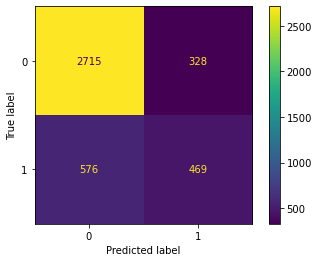

In [72]:
plot_confusion_matrix(final_pipe, X_inc_test,y_inc_test)
#ConfusionMatrixDisplay.from_estimator(final_pipe, X_inc_test,y_inc_test);

Probably needs some tuning. Let's look at the steps of final_pipe.

In [73]:
print(final_pipe.steps)

[('preprocess', ColumnTransformer(transformers=[('ordinalpipe',
                                 Pipeline(steps=[('ordimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordenc',
                                                  OrdinalEncoder(categories=[['10th',
                                                                              '11th',
                                                                              'HS-grad',
                                                                              'Some-college',
                                                                              'Assoc-acdm',
                                                                              'Assoc-voc',
                                                                              'Bachelors',
                                                                              'Masters',
  

In [74]:
# going down each level in estimator with double underscore (level1__level2__estimator__argument)
final_pipe_grid = {'preprocess__numpipe__numimputer__strategy': ["mean", "median"],
             'model__n_neighbors': [3, 11, 15],
             'model__p': [1, 2]}

gs_full_pipe = GridSearchCV(estimator=final_pipe, 
                       param_grid=final_pipe_grid)

In [75]:
gs_full_pipe.fit(X_inc_train,y_inc_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('ordinalpipe',
                                                                         Pipeline(steps=[('ordimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordenc',
                                                                                          OrdinalEncoder(categories=[['10th',
                                                                                                                      '11th',
                                                                                                                      'HS-grad',
                                                                                                                      'Some-college',
                                                                                                                      'Assoc-acdm',
                                                                                                                      'Assoc-voc',
                                                                                                                      'Bachelors',
                                                                                                                      'Masters',
                                                                                                                      'Doctorate']])),
                                                                                         ('ordnorm',
                                                                                          StandardScaler())]),
                                                                         ['educat...
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         ['occupation',
                                                                          'sex']),
                                                                        ('numpipe',
                                                                         Pipeline(steps=[('numimputer',
                                                                                          SimpleImputer()),
                                                                                         ('numnorm',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'hours.per.week'], dtype='object'))])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [3, 11, 15], 'model__p': [1, 2],
                         'preprocess__numpipe__numimputer__strategy': ['mean',
                                                                       'median']})

In [76]:
gs_full_pipe.best_score_

0.7948709919489493

In [77]:
gs_full_pipe.best_params_

{'model__n_neighbors': 15,
 'model__p': 1,
 'preprocess__numpipe__numimputer__strategy': 'mean'}

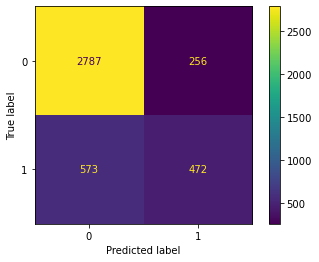

In [78]:
best_model = gs_full_pipe.best_estimator_
y_pred = best_model.predict(X_inc_test)
plot_confusion_matrix(best_model,X_inc_test,y_inc_test)
#ConfusionMatrixDisplay.from_estimator(best_model,X_inc_test,y_inc_test);

Try a different scoring metric due to class imbalance

In [ ]:
# going down each level in estimator with double underscore (level1__level2__estimator__argument)
final_pipe_grid = {'preprocess__numpipe__numimputer__strategy': ["mean", "median"],
             'model__n_neighbors': [3, 11, 15],
             'model__p': [1, 2]}

gs_full_pipe2 = GridSearchCV(estimator=final_pipe, 
                       param_grid=final_pipe_grid, scoring = 'roc_auc')

In [ ]:
gs_full_pipe2.fit(X_inc_train, y_inc_train)
best_model2 = gs_full_pipe2.best_estimator_
#plot_confusion_matrix(best_model2, X_inc_test,y_inc_test)
ConfusionMatrixDisplay.from_estimator(best_model2, X_inc_test,y_inc_test);

Scoring made a difference, but not that much. In some case will make a *huge* difference.

Probably would do much better with a better classifier and a better tuning range:
- But now you see how to address hyperparameters inside column transformers
- At any level of the full pipeline
- Change metrics you are tuning on

#### Feature Union

Given a subset of features:
- Want to transform feature subset in multiple ways (in parallel)
- Keep all of these transformed subsets as features
- **Feature Union** of multiple transformers

- E.g. PolynomialFeatures
- Function transformer (transform features according to function)

In [79]:
from scipy.stats import norm
X = np.linspace(-1.7*np.pi, 1.5*np.pi, 100)
np.random.shuffle(X)
epsilon = norm.rvs(loc = 0, scale = 3.5, size = 100)
y = 5*np.sin(2*X) - 3*np.cos(X) + 2*X + .3*X**2 + epsilon
data_df = pd.DataFrame()
data_df['X'] = X
data_df['y'] = y

In [80]:
data_df

,X,y
0,0.244346,-1.213534
1,1.970635,-0.170843
2,1.869089,7.297073
3,3.798471,20.355971
4,4.610843,17.985921
...,...,...
95,-1.685036,-5.056387
96,-5.137615,-1.885991
97,-4.731429,-2.338899
98,2.579914,-5.430617


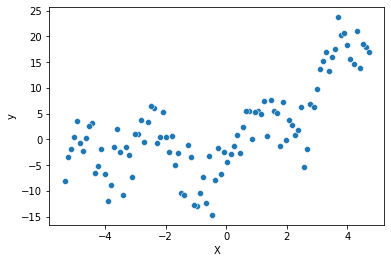

In [81]:
sns.scatterplot(x = 'X', y = 'y', data = 
                data_df)
plt.show()

In [82]:
X_reshape = data_df['X'].values.reshape(-1,1)
y = data_df['y']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_reshape, y, test_size = 0.2)

In [84]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

Let's also define two custom functions:

In [85]:
def sinefunc(x, c = 1):
    return np.sin(c*x)

In [86]:
def cosfunc(x, d = 1):
    return np.cos(d*x)

In [87]:
transformer_list = [('poly', PolynomialFeatures(include_bias = False)), 
                     ('sine', FunctionTransformer(sinefunc)), 
                     ('cosine', FunctionTransformer(cosfunc))
                   ]

# takes in input features, applies transformers in parallel to inputs, concatenates:
feat_union = FeatureUnion(transformer_list) 

In [88]:
steps = [('feateng', feat_union), ('scaler', StandardScaler())]
preprocess_pipe = Pipeline(steps)
preprocess_pipe

Pipeline(steps=[('feateng',
                 FeatureUnion(transformer_list=[('poly',
                                                 PolynomialFeatures(include_bias=False)),
                                                ('sine',
                                                 FunctionTransformer(func=<function sinefunc at 0x18d7baaf0>)),
                                                ('cosine',
                                                 FunctionTransformer(func=<function cosfunc at 0x15561dee0>))])),
                ('scaler', StandardScaler())])

In [89]:
X_proc = preprocess_pipe.fit_transform(X_train)
X_proc[0:5]

array([[ 0.10891462, -1.02946701,  0.30453268,  1.65848954],
       [ 1.00533129, -0.03609562,  0.45383313, -1.19301894],
       [-1.46877871,  1.2686571 ,  1.18233482, -0.49472314],
       [-1.50463537,  1.38086434,  1.24127646, -0.3572473 ],
       [ 1.61489462,  1.59103423, -1.36797532, -0.09426258]])

First column is linear in X, second quadratic in X, then the sin and cosine terms.

- Check if all standard scaled:

In [90]:
print(X_proc.mean(axis = 0))

[-1.80411242e-17  1.37390099e-16  3.33066907e-17 -2.60208521e-17]


In [91]:
print(X_proc.std(axis = 0))

[1. 1. 1. 1.]


Finish pipeline and hyperparameter tune:

In [107]:
steps = [('preprocess', preprocess_pipe), ('ridge', Ridge())]
regress_pipe = Pipeline(steps)
params = {'preprocess__feateng__poly__degree': [1, 2, 3, 4], 
          'preprocess__feateng__sine__kw_args': [{'c': 1},{'c': 2},{'c': 3}],
          'ridge__alpha': [1e-3, .01, .1, 1, 10, 100]}
cv = GridSearchCV(estimator = regress_pipe, param_grid = params, cv = 6)
cv.fit(X_train, y_train)
best_model = cv.best_estimator_

In [108]:
best_model.steps

[('preprocess',
  Pipeline(steps=[('feateng',
                   FeatureUnion(transformer_list=[('poly',
                                                   PolynomialFeatures(degree=4,
                                                                      include_bias=False)),
                                                  ('sine',
                                                   FunctionTransformer(func=<function sinefunc at 0x18d7baaf0>,
                                                                       kw_args={'c': 2})),
                                                  ('cosine',
                                                   FunctionTransformer(func=<function cosfunc at 0x15561dee0>))])),
                  ('scaler', StandardScaler())])),
 ('ridge', Ridge(alpha=0.1))]

In [94]:
cv.best_score_

0.8166696732423558

In [95]:
cv.best_params_

{'preprocess__feateng__poly__degree': 4,
 'preprocess__feateng__sine__kw_args': {'c': 2},
 'ridge__alpha': 0.1}

In [96]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocess__feateng__poly__degree,param_preprocess__feateng__sine__kw_args,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002823,0.001883,0.000945,0.000106,1,{'c': 1},0.001,"{'preprocess__feateng__poly__degree': 1, 'prep...",0.539643,0.605523,0.654625,0.273960,0.422375,0.776925,0.545508,0.162274,61
1,0.002065,0.000131,0.000946,0.000051,1,{'c': 1},0.01,"{'preprocess__feateng__poly__degree': 1, 'prep...",0.539656,0.605534,0.654591,0.273988,0.422389,0.776909,0.545511,0.162257,60
2,0.001792,0.000088,0.000838,0.000039,1,{'c': 1},0.1,"{'preprocess__feateng__poly__degree': 1, 'prep...",0.539787,0.605644,0.654260,0.274269,0.422529,0.776749,0.545540,0.162092,59
3,0.001615,0.000090,0.000751,0.000022,1,{'c': 1},1,"{'preprocess__feateng__poly__degree': 1, 'prep...",0.540947,0.606606,0.650905,0.276945,0.423786,0.775062,0.545708,0.160468,58
4,0.001290,0.000088,0.000604,0.000009,1,{'c': 1},10,"{'preprocess__feateng__poly__degree': 1, 'prep...",0.540974,0.605526,0.614647,0.293075,0.425602,0.751506,0.538555,0.146429,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.001232,0.000014,0.000595,0.000001,4,{'c': 3},0.01,"{'preprocess__feateng__poly__degree': 4, 'prep...",0.511199,0.654391,0.821568,0.586499,0.580353,0.790390,0.657400,0.113273,34
68,0.001241,0.000025,0.000604,0.000013,4,{'c': 3},0.1,"{'preprocess__feateng__poly__degree': 4, 'prep...",0.537025,0.658976,0.822078,0.586907,0.583351,0.790096,0.663072,0.107610,32
69,0.001300,0.000039,0.000624,0.000002,4,{'c': 3},1,"{'preprocess__feateng__poly__degree': 4, 'prep...",0.582943,0.669068,0.821349,0.587787,0.590297,0.791765,0.673868,0.098603,27
70,0.001285,0.000004,0.000627,0.000003,4,{'c': 3},10,"{'preprocess__feateng__poly__degree': 4, 'prep...",0.600442,0.671081,0.802261,0.583244,0.584798,0.811793,0.675603,0.097498,26


In [97]:
best_model.fit(X_train, y_train)
y_predictions = best_model.predict(data_df['X'].values.reshape(-1,1))

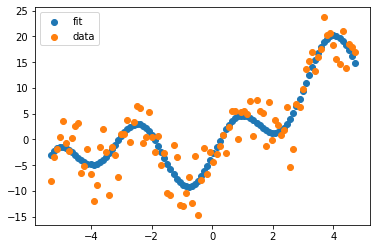

In [98]:
fig, ax = plt.subplots()
ax.scatter(X, y_predictions, label = 'fit')
ax.scatter(X, y, label = 'data')
ax.legend()
plt.show()

In [99]:
y_pred = best_model.predict(X_test)

In [100]:
mean_absolute_error(y_pred, y_test)

3.4063525270868853

Can use Pipelines, FeatureUnions, FunctionTransformers:
- to systematically search basis function spaces
- Get best fits based off series of functions
- Best function selection

**Obviously very powerful**

Combining FeatureUnion with ColumnTransformer:
- Apply function finding/feature engineering of different kinds to different columns
- Input transformed features into various types of predictive models (with regularization/hyperparameter tuning)

**Now can start to build very powerful/flexible models**

Kind of like building legos. 
- Maybe you want some extra pieces
- Model/Transformer extensions
- Treat models like transformers in FeatureUnion (parallel modeling)
- Get an expansion pack!


May be worth exploring **sklego**:
<center><img src = "Images/sklego.png" width = 300 /></center>

<center>https://scikit-lego.netlify.app/</center>

#### Optimizing tuning strategies

As models/pipelines get complex:
- Lots of hyperparameters to play around with
- GridSearch not the best **initial** strategy:
    - Takes forever
    - Want to sample space more effectively.

Randomized Search CV

<img src = "Images/grid_vs_randomcv.png" />

<center>Often smaller number of random hyperparamter samples better than grid search.</center>

In [109]:
from sklearn.model_selection import RandomizedSearchCV

Basically same syntax as GridSearchCV:
- param_distributions: 
    - can take dict of hyperparameters with value list: uniformly samples
    - can take dict of hyperparameters with specified distributions.
- n_iter is # of samples to take.

In [102]:
# will uniformly random sample this grid.
params

{'preprocess__feateng__poly__degree': [1, 2, 3, 4],
 'preprocess__feateng__sine__kw_args': [{'c': 1}, {'c': 2}, {'c': 3}],
 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [103]:
random_cv = RandomizedSearchCV(estimator = regress_pipe, param_distributions = params, n_iter = 10, cv = 6)
random_cv.fit(X_train, y_train);

In [104]:
randomcv_results = pd.DataFrame(random_cv.cv_results_)
randomcv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,param_preprocess__feateng__sine__kw_args,param_preprocess__feateng__poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002203,0.000184,0.000957,0.000054,0.1,{'c': 1},1,"{'ridge__alpha': 0.1, 'preprocess__feateng__si...",0.539787,0.605644,0.654260,0.274269,0.422529,0.776749,0.545540,0.162092,9
1,0.002494,0.000678,0.001097,0.000263,0.01,{'c': 2},4,"{'ridge__alpha': 0.01, 'preprocess__feateng__s...",0.790785,0.873913,0.929647,0.791005,0.774667,0.738697,0.816452,0.064824,1
2,0.001884,0.000101,0.000876,0.000046,100,{'c': 3},3,"{'ridge__alpha': 100, 'preprocess__feateng__si...",0.445404,0.537046,0.525545,0.409740,0.401301,0.651454,0.495082,0.087261,10
3,0.001579,0.000040,0.000758,0.000013,1,{'c': 1},1,"{'ridge__alpha': 1, 'preprocess__feateng__sine...",0.540947,0.606606,0.650905,0.276945,0.423786,0.775062,0.545708,0.160468,8
4,0.001334,0.000082,0.000632,0.000032,1,{'c': 1},2,"{'ridge__alpha': 1, 'preprocess__feateng__sine...",0.685650,0.619999,0.790151,0.515586,0.488133,0.818602,0.653020,0.125468,6


In [105]:
best_random = random_cv.best_estimator_
best_random

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('feateng',
                                  FeatureUnion(transformer_list=[('poly',
                                                                  PolynomialFeatures(degree=4,
                                                                                     include_bias=False)),
                                                                 ('sine',
                                                                  FunctionTransformer(func=<function sinefunc at 0x18d7baaf0>,
                                                                                      kw_args={'c': 2})),
                                                                 ('cosine',
                                                                  FunctionTransformer(func=<function cosfunc at 0x15561dee0>))])),
                                 ('scaler', StandardScaler())])),
                ('ridge', Ridge(alpha=0.01))])

In [106]:
random_cv.best_score_

0.8164523413447101

Then after promising RandomSearchCV():
- GridSearchCV (possibly):
    - select best hyperparameter from random search.
    - fine step grid search tuning around this point.

This is just the beginning of hyperperparameter tuning strategies:
- Principled Bayesian approaches exist, etc.
- That being said, RandomSearchCV used well is **very** effective